# 11_debug_AS.ipynb

In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import libraries

In [111]:
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt

from lob_market_making_sim.io import loader
from lob_market_making_sim.io.schema import Direction, EventType
from lob_market_making_sim.core.order_book import OrderBookL1
from lob_market_making_sim.core.engine import ReplayEngine
from lob_market_making_sim.models.avellaneda import ASParams, AvellanedaStoikov

# do not show warnings
import warnings
warnings.filterwarnings("ignore")

## Load one day

In [112]:
df = pd.read_parquet("data/parquet/AMZN_2025-06-12.parquet")   # change path
events = loader.arrow_to_events(pa.Table.from_pandas(df))

## Run the engine

In [113]:
asparams = ASParams(
    gamma = 0.02,
    kappa = 100.0,
    sigma = 0.30,          # $ / sqrt(sec)
    qmax  = 1_000
)
strategy = AvellanedaStoikov(params=asparams)
ob = OrderBookL1()
engine = ReplayEngine(ob, strategy)
engine.run(events)

print(f"cash   = {engine.cash:,.0f}")
print(f"p&l: {engine.cash + engine.inv * engine.ob.midprice()}")
print(f"inv    = {engine.inv:,.0f}")
print(f"fills  = {sum(1 for _,_,_,_,inv in engine.quote_log if inv!=0)} steps had inventory")

JUMP @ ts=34200.873785004  best_bid=223.8850009998667 best_ask=223.90499900013333  agent_bid=OrderRec(direction=<Direction.BUY: 1>, price=223.8850009998667, quantity=10) agent_ask=OrderRec(direction=<Direction.SELL: -1>, price=223.90499900013333, quantity=10)
JUMP @ ts=34200.881781052  best_bid=223.8850009998667 best_ask=223.90499900013333  agent_bid=OrderRec(direction=<Direction.BUY: 1>, price=223.8850009998667, quantity=10) agent_ask=OrderRec(direction=<Direction.SELL: -1>, price=223.90499900013333, quantity=10)
JUMP @ ts=34203.87899164  best_bid=224.0350009998667 best_ask=224.05499900013334  agent_bid=OrderRec(direction=<Direction.BUY: 1>, price=224.0350009998667, quantity=10) agent_ask=OrderRec(direction=<Direction.SELL: -1>, price=224.05499900013334, quantity=10)
JUMP @ ts=34212.377481694  best_bid=223.9650009998667 best_ask=223.98499900013334  agent_bid=OrderRec(direction=<Direction.BUY: 1>, price=223.9650009998667, quantity=10) agent_ask=OrderRec(direction=<Direction.SELL: -1>, 

## Side-by-side fill counts

In [114]:
bid_hits  = 0
ask_hits  = 0
for ev in events:
    if ev.etype not in {EventType.EXECUTE_VISIBLE, EventType.CROSS}:
        continue
    if ev.direction is Direction.BUY:
        ask_hits += 1
    else:
        bid_hits += 1
print(f"market executed bids={bid_hits:,}  asks={ask_hits:,}")

print(f"our fills  BUY={engine.filled_buy}  "
      f"SELL={engine.filled_sell}")  # if you track them

market executed bids=4,808  asks=4,166
our fills  BUY=40  SELL=140


## How far from the street are we?

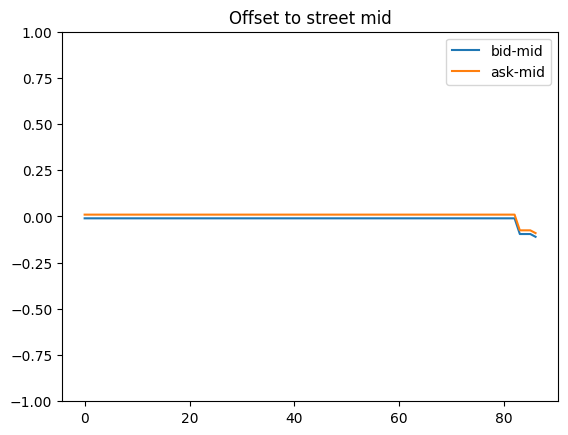

In [115]:
best_bids = [row[1] for row in engine.quote_log]    # agent side
best_asks = [row[2] for row in engine.quote_log]
mids      = [row[3] for row in engine.quote_log]    # our mid (incl. ourselves)

# reconstruct a *clean* mid without our orders
clean_mids = []
tmp_ob = OrderBookL1()
for ev in events:
    tmp_ob.apply(ev)
    if tmp_ob.best_bid.price and tmp_ob.best_ask.price:
        clean_mids.append((tmp_ob.best_bid.price + tmp_ob.best_ask.price)/2)

plt.figure()
plt.title("Offset to street mid")
plt.plot([b-m for b,m in zip(best_bids, clean_mids)], label="bid-mid")
plt.plot([a-m for a,m in zip(best_asks, clean_mids)], label="ask-mid")
plt.ylim(-1, 1)
plt.legend(); plt.show()

## Inventory path

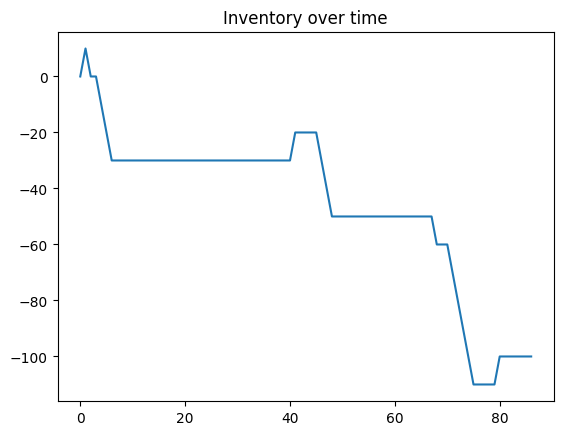

In [116]:
plt.figure()
plt.plot([row[4] for row in engine.quote_log])
plt.title("Inventory over time")
plt.show()